In [15]:
# Importa le librerie necessarie
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Crea una sessione Spark
spark = SparkSession.builder.appName("StudentDepressionRandomForest").getOrCreate()

# Carica il dataset da Google Cloud Storage
df = spark.read.csv("gs://big-data-bucket-test/dataset/EDA_Student_Depression_Dataset.csv", header=True, inferSchema=True)

In [16]:
# Visualizza le prime righe del dataframe
df.show(5)

# Preprocessing: Creazione della feature "features" combinando tutte le colonne numeriche
columns = df.columns
# Rimuovi la colonna target 'Depression'
columns.remove('Depression')

+------+----+-----------------+----+------------------+--------------+------------------------------------+----------------+----------------+--------------------------------+----------+-------------+----------------------+-----------------------+------------------------+---------------+------------------+------------------+
|Gender| Age|Academic_Pressure|CGPA|Study_Satisfaction|Sleep_Duration|Have_you_ever_had_suicidal_thoughts?|Work/Study_Hours|Financial_Stress|Family_History_of_Mental_Illness|Depression|Is_Metropolis|Dietary_Habits_Healthy|Dietary_Habits_Moderate|Dietary_Habits_Unhealthy|Degree_bachelor|Degree_high_school|Degree_masters_phd|
+------+----+-----------------+----+------------------+--------------+------------------------------------+----------------+----------------+--------------------------------+----------+-------------+----------------------+-----------------------+------------------------+---------------+------------------+------------------+
|     1|33.0|         

In [17]:
# Creazione del VectorAssembler per combinare tutte le features in un'unica colonna
assembler = VectorAssembler(inputCols=columns, outputCol="features")

# Crea il modello di Random Forest
rf = RandomForestClassifier(labelCol="Depression", featuresCol="features", numTrees=10, maxDepth=5)

# Costruisci il pipeline
pipeline = Pipeline(stages=[assembler, rf])


In [18]:
# Splitta i dati in training e test (80% training, 20% test)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)


In [19]:
# Inizio della misurazione del tempo di addestramento
start_time = time.time()

# Addestra il modello
pipeline_model = pipeline.fit(train_data)

# Fine della misurazione del tempo di addestramento
end_time = time.time()

In [20]:
# Calcola e stampa il tempo di addestramento
training_time = end_time - start_time
print(f"Tempo di addestramento: {training_time:.2f} secondi")

Tempo di addestramento: 4.59 secondi


In [21]:
# Fai le predizioni sul set di test
predictions = pipeline_model.transform(test_data)

# Visualizza le prime 50 predizioni
predictions.select("prediction", "Depression").show(50)


+----------+----------+
|prediction|Depression|
+----------+----------+
|       1.0|         0|
|       0.0|         0|
|       0.0|         0|
|       0.0|         0|
|       0.0|         0|
|       0.0|         0|
|       1.0|         1|
|       0.0|         0|
|       0.0|         0|
|       0.0|         0|
|       1.0|         1|
|       0.0|         0|
|       0.0|         0|
|       1.0|         0|
|       0.0|         1|
|       0.0|         0|
|       1.0|         1|
|       0.0|         0|
|       0.0|         0|
|       1.0|         1|
|       0.0|         0|
|       1.0|         1|
|       1.0|         1|
|       1.0|         1|
|       1.0|         1|
|       1.0|         0|
|       0.0|         0|
|       0.0|         0|
|       0.0|         0|
|       0.0|         1|
|       1.0|         1|
|       1.0|         0|
|       1.0|         0|
|       1.0|         1|
|       1.0|         0|
|       1.0|         1|
|       0.0|         1|
|       1.0|         1|
|       1.0|    

In [22]:
# Valuta il modello utilizzando l'AUC
evaluator = BinaryClassificationEvaluator(labelCol="Depression")
auc = evaluator.evaluate(predictions)

print(f"AUC: {auc}")

AUC: 0.9013749023704383


In [23]:
# Calcolare altre metriche come l'accuratezza
t_test = predictions.select('Depression').toPandas()
t_hat = predictions.select('prediction').toPandas()

print(f"\nAccuracy score on the test set: {accuracy_score(t_test, t_hat)}")
print(f"\nClassification Report:\n{classification_report(t_test, t_hat)}")


Accuracy score on the test set: 0.8336043360433605

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      2264
           1       0.83      0.90      0.86      3271

    accuracy                           0.83      5535
   macro avg       0.83      0.82      0.82      5535
weighted avg       0.83      0.83      0.83      5535



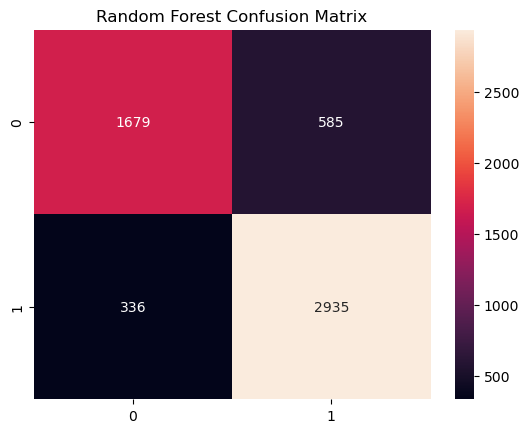

In [24]:
# Confusion Matrix
cm = confusion_matrix(t_test, t_hat)
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
ax.set_title('Random Forest Confusion Matrix')
plt.show()